In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import cv2
import numpy as np
from torchvision import transforms


In [2]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resize to match input size of U-Net
    # transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_mask = transforms.Compose([

    transforms.Resize((256, 256))  # Resize to match input size of U-Net

])


In [3]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, coco_annotation_file, image_dir, transform=None):
        self.coco = COCO(coco_annotation_file)  # Load the annotations.json for the respective subset
        self.image_dir = image_dir
        self.transform = transform
        self.ids = list(self.coco.imgs.keys())
    
    def __len__(self):
            return len(self.ids)
        

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        # print(img_info)
        img_path = f"{self.image_dir}/{img_info['file_name']}"
        image = cv2.imread(img_path)
        # cv2.imshow('hi', image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Create empty mask
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        
        # Draw masks for each annotation (each object)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))  # Merge masks

        # cv2.imshow('hi', image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        # print(image.shape)
        # print(mask.shape)
        if self.transform:
            # Transform image and mask to tensor
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
            # print(image.shape)
            # print(mask.shape)
            # cv2.imshow('hi', image)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
            # print(image.shape)
            # print(mask.shape)
            mask = transform_mask(mask)

            
        # print(image.shape, print(mask.shape))
        return image, mask




In [4]:
train_dataset = CocoSegmentationDataset(coco_annotation_file='train/_annotations.coco.json', image_dir='train', transform=transform)
valid_dataset = CocoSegmentationDataset(coco_annotation_file='valid/_annotations.coco.json', image_dir='valid', transform=transform)
test_dataset = CocoSegmentationDataset(coco_annotation_file='test/_annotations.coco.json', image_dir='test', transform=transform)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [6]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )
        
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
                
        self.pool = nn.MaxPool2d(2, 2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder
        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat((d4, e4), dim=1))
        
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat((d3, e3), dim=1))
        
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat((d2, e2), dim=1))
        
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat((d1, e1), dim=1))
        
        return self.final(d1)


In [7]:
import torch.optim as optim

# Hyperparameters
batch_size = 8
learning_rate = 1e-4
epochs = 100

# Initialize model, loss function, and optimizer
model = UNet(in_channels=3, out_channels=1).to("cuda")  # For binary segmentation
criterion = nn.BCEWithLogitsLoss()  # Loss function for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to("cuda"), masks.to("cuda")
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, masks)
        running_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    
    # Optionally, you can add validation loop here to evaluate the model's performance.


Epoch 1/100, Loss: 0.6334985991319021
Epoch 2/100, Loss: 0.47068427006403607
Epoch 3/100, Loss: 0.19620059430599213
Epoch 4/100, Loss: 0.1211345475167036
Epoch 5/100, Loss: 0.06577234684179227
Epoch 6/100, Loss: 0.038450890220701694
Epoch 7/100, Loss: 0.029091392643749714
Epoch 8/100, Loss: 0.025203265404949587
Epoch 9/100, Loss: 0.02312011830508709
Epoch 10/100, Loss: 0.02208736725151539
Epoch 11/100, Loss: 0.020652168430387974
Epoch 12/100, Loss: 0.01925166541089614
Epoch 13/100, Loss: 0.017695083748549223
Epoch 14/100, Loss: 0.016408261532584827
Epoch 15/100, Loss: 0.014730256671706835
Epoch 16/100, Loss: 0.014386893017217517
Epoch 17/100, Loss: 0.0134831212926656
Epoch 18/100, Loss: 0.013780581066384912
Epoch 19/100, Loss: 0.014475480886176229
Epoch 20/100, Loss: 0.013600939263900122
Epoch 21/100, Loss: 0.01308898899393777
Epoch 22/100, Loss: 0.012846715205038587
Epoch 23/100, Loss: 0.012903984170407057
Epoch 24/100, Loss: 0.013009657229607305
Epoch 25/100, Loss: 0.0126154560130089

In [9]:
model.eval()  # Set model to evaluation mode
test_loss = 0.0

with torch.no_grad():  # Disable gradient calculation
    for images, masks in test_loader:
        images, masks = images.to("cuda"), masks.to("cuda")
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader)}")

Test Loss: 0.01173366466537118


In [12]:
print(images.shape())

TypeError: 'torch.Size' object is not callable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1072767..2.64].


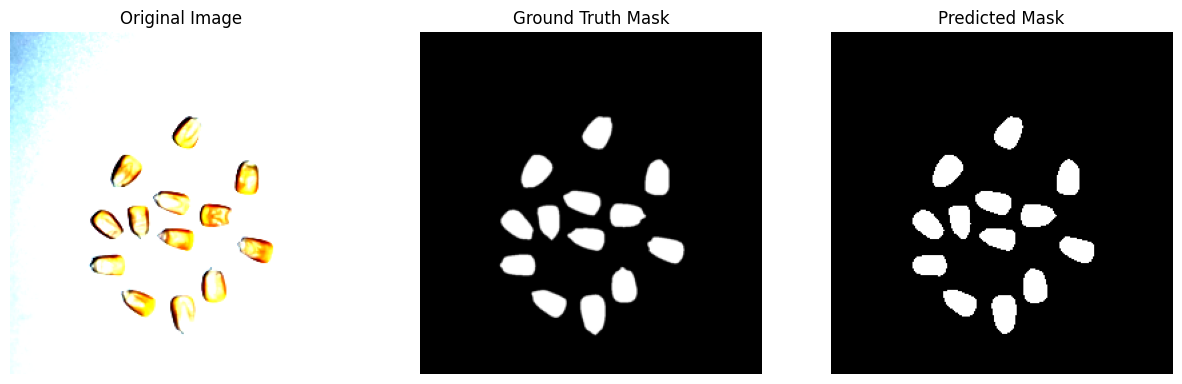

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1595641..2.64].


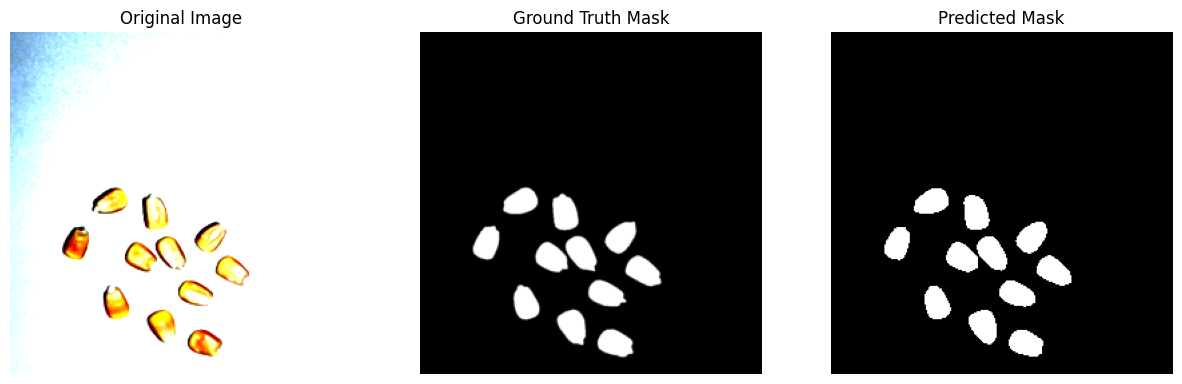

In [10]:
import numpy
import matplotlib.pyplot as plt
def visualize_segmentation(model, dataloader, device="cuda"):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculations
        for images, masks in dataloader:  # Load batch of images and masks
            images = images.to(device)  # Move images to GPU
            masks = masks.to(device)    # Move ground-truth masks to GPU
            
            outputs = model(images)  # Perform inference to get predictions
            
            # Move tensors to CPU for visualization
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            outputs = outputs.cpu().numpy()
            
            # Process and visualize the first image in the batch
            for i in range(min(3, len(images))):  # Display up to 3 images
                original_image = images[i].transpose(1, 2, 0)  # Convert from CHW to HWC
                ground_truth_mask = masks[i][0]  # Single-channel ground truth
                predicted_mask = outputs[i][0]  # Single-channel predicted mask
                
                # Threshold predicted mask to make it binary
                predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

                # Plot images side by side
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(original_image, )
                axes[0].set_title("Original Image")
                axes[0].axis("off")
                
                axes[1].imshow(ground_truth_mask, cmap="gray")
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis("off")

                axes[2].imshow(predicted_mask_binary, cmap="gray")
                axes[2].set_title("Predicted Mask")
                axes[2].axis("off")

                plt.show()
            break  # Visualize only one batch

# Example: Use the validation dataloader to visualize
visualize_segmentation(model, test_loader, device="cuda")


In [ ]:
import numpy
import matplotlib.pyplot as plt
def visualize_segmentation(model, dataloader, device="cuda"):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculations
        for images, masks in dataloader:  # Load batch of images and masks
            images = images.to(device)  # Move images to GPU
            masks = masks.to(device)    # Move ground-truth masks to GPU
            
            outputs = model(images)  # Perform inference to get predictions
            
            # Move tensors to CPU for visualization
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            outputs = outputs.cpu().numpy()
            
            # Process and visualize the first image in the batch
            for i in range(min(3, len(images))):  # Display up to 3 images
                original_image = images[i].transpose(1, 2, 0)  # Convert from CHW to HWC
                ground_truth_mask = masks[i][0]  # Single-channel ground truth
                predicted_mask = outputs[i][0]  # Single-channel predicted mask
                
                # Threshold predicted mask to make it binary
                predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

                # Plot images side by side
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(original_image, )
                axes[0].set_title("Original Image")
                axes[0].axis("off")
                
                axes[1].imshow(ground_truth_mask, cmap="gray")
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis("off")

                axes[2].imshow(predicted_mask_binary, cmap="gray")
                axes[2].set_title("Predicted Mask")
                axes[2].axis("off")

                plt.show()
            break  # Visualize only one batch

# Example: Use the validation dataloader to visualize
visualize_segmentation(model, test_loader, device="cuda")


In [14]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np

# Function to segment a single image using a trained model
def segment_single_image(model, image_path, device="cuda", input_size=(2, 800)):
    """
    Segment an image using the trained U-Net model.
    
    Parameters:
        model (torch.nn.Module): Trained U-Net model.
        image_path (str): Path to the input image.
        device (str): Device to use ("cuda" or "cpu").
        input_size (tuple): Size to resize the input image (height, width).
    """
    # Set model to evaluation mode
    model.eval()
    
    # Load and preprocess the image
    original_image = cv2.imread(image_path)  # Read image
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    resized_image = cv2.resize(original_image, input_size)  # Resize to match model input size
    
    # Normalize and convert to tensor
    image_tensor = torch.from_numpy(resized_image).float() / 255.0  # Normalize to [0, 1]
    image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0)  # Reshape to [1, 3, H, W]
    image_tensor = image_tensor.to(device)  # Move to the appropriate device
    
    # Perform inference
    with torch.no_grad():  # Disable gradient calculations
        output = model(image_tensor)  # Get model prediction
        output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
        output = output.cpu().numpy()  # Move to CPU and convert to NumPy

    # Process output to binary mask
    predicted_mask = output[0, 0]  # Remove batch and channel dimensions
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)  # Threshold to binary mask

    # Plot the original image and predicted mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(resized_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(predicted_mask_binary, cmap="gray")
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")
    
    plt.show()

# Provide the path to an image
image_path = "path/to/your/image.jpg"

# Call the function to segment and visualize the image
segment_single_image(model, image_path, device="cuda", input_size=(800, 800))


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [11]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms

# Define the same transformation as used during training
transform = transforms.Compose([
    transforms.ToPILImage(),                      # Convert to PIL Image
    transforms.Resize((256, 256)),                # Resize to match U-Net input size
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Function to segment a single image using the trained model
def segment_single_image(model, image_path, device="cuda"):
    """
    Segment an image using the trained U-Net model.
    
    Parameters:
        model (torch.nn.Module): Trained U-Net model.
        image_path (str): Path to the input image.
        device (str): Device to use ("cuda" or "cpu").
    """
    # Set model to evaluation mode
    model.eval()
    
    # Load and preprocess the image
    original_image = cv2.imread(image_path)  # Read the image
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    # Apply the same transformations as during training
    input_tensor = transform(original_image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)  # Forward pass
        output = torch.sigmoid(output)  # Apply sigmoid activation
        output = output.cpu().numpy()  # Move to CPU and convert to NumPy
    
    # Post-process the prediction
    predicted_mask = output[0, 0]  # Remove batch and channel dimensions
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)  # Threshold to binary mask
    
    # Plot the original image and predicted mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(predicted_mask_binary, cmap="gray")
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")
    
    plt.show()


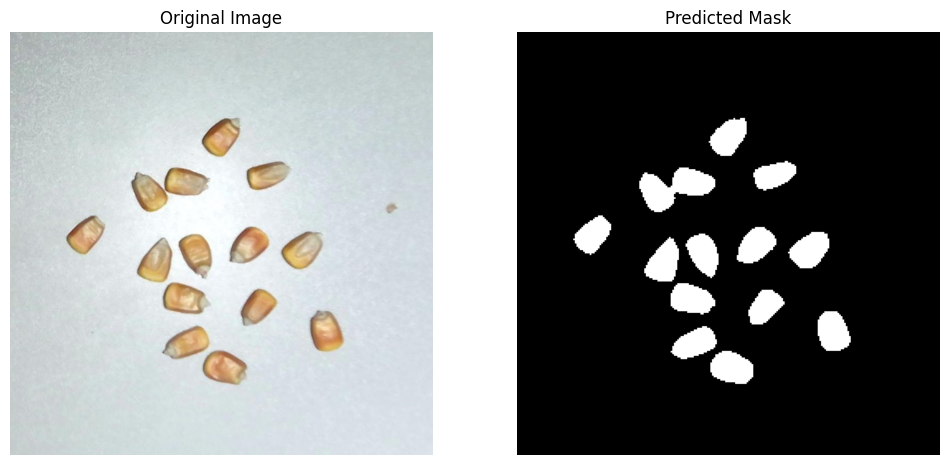

In [12]:
image_path = "valid/017124_0000_1787474_1713947339592_Color_3840x2160_png.rf.9e5093cec27cc56da9c43151713c944d.jpg"

# Call the function to segment and visualize the image
segment_single_image(model, image_path, device="cuda")
